In [1]:
import random
import string
import shutil
import os

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler import CouplingMap
from qiskit_aer.primitives import EstimatorV2

from simulation import (
    build_hamiltonian,
    cut_circuit,
    run_exact_sampler,
    run_mps_simulator_knitted,
    run_statevector_simulator_full,
    reconstruct_expectation,
    trotterization_circuit,
)
from utils import circuit_data_dict, save_to_json


In [2]:
#Function for nicer graph visualization
def plot_coupling_map(coupling_map, num_rings, num_spins):

    G = nx.Graph()
    G.add_edges_from(coupling_map.get_edges())
    
    node_labels = {i: f"Q{i}" for i in G.nodes()}
    
    # This is an iterative algorithm, results may vary
    pos = nx.spring_layout(G, iterations = 1000, weight = 1,seed = 3)

    plt.figure(figsize=(10, 8))
    plt.title("Hamiltonian Coupling Map", fontsize=16)
    nx.draw_networkx_edges(G, pos, width=2, alpha=0.7, edge_color='black')
    nx.draw_networkx_nodes(G, pos, node_size=700, node_color='skyblue',
                           edgecolors='black', linewidths=1.5)

    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=12, font_weight='bold')

    plt.axis('off')
    plt.tight_layout()
    plt.show()

This code creates the knitted/not knitted circuit, performs full simulation of those circuits classically and with MPS, and generates a .json for use in Julia. 

=== Configuration ===
Number of Spins per Ring: 10
Number of Rings: 2
Anisotropy (J): 0.98
External Magnetic Field (H): 1.0
Two-Qubit Gates: ['XX']
Single-Qubit Gates: ['Z']
Trotter Repetitions: 2
Time Parameter (t): 100
Decreasing J Flag: False
Number of circuit samples: inf
Number of shots (tensor simulation): 100
=== Coupling Map === 


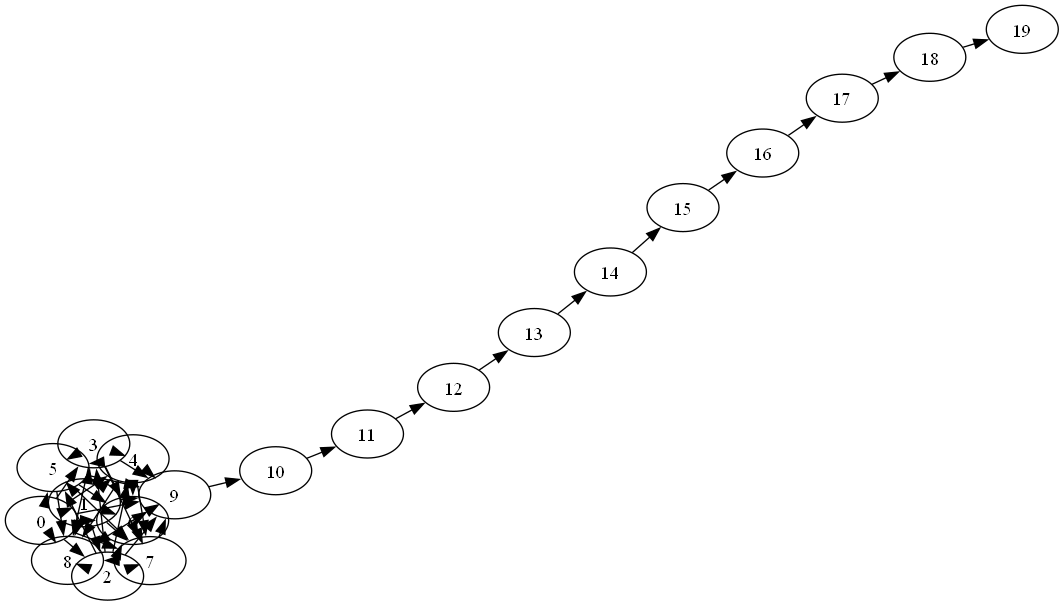

Obtained full circuit
Running simulation without knitting
Run statevector simulation:  5.868498724055658
Subcircuits data has been successfully saved to 'subcircuits/subcircuits.json'.


In [4]:
def main(config):
    config.display_configuration()
    # Define Copling map for qubits and total number of qubits
    num_qubits = config.NUM_RINGS * config.NUM_SPINS
    edges = config.EDGES
    coupling_map = CouplingMap(edges)

    print("=== Coupling Map === ")
    display(coupling_map.draw())
    # Better-looking coupling map plot (maybe for report)
    # plot_coupling_map(coupling_map, config.NUM_RINGS, config.NUM_SPINS)
    
    # Build Hamiltonian
    H = build_hamiltonian(
        num_qubits=num_qubits,
        coupling_map=coupling_map,
        decrease=config.DECREASING,
        initial_qubit_decrease=config.INDEX_DECREASE,
        single_gates=config.SINGLE_GATES_LIST,
        two_gates=config.TWO_GATES_LIST,
        anisotropy=config.ANISOTROPY,
        h=config.H_FIELD
    )
    
    initialState = QuantumCircuit(num_qubits)
    #Obtain evolution circuit under TrotterLie approximation
    evolutionQC = trotterization_circuit(hamiltonian = H, trotter_reps = config.TROTTER_REPS, t = config.T)
    totalQC = initialState.compose(evolutionQC) #Try option preserve_order
    # display(totalQC.draw('mpl', fold = False))
    print('Obtained full circuit')

    # Define observables (Z on each site, ZII + IZI + IIZ)
    z_list = [('Z', [i], 1.0) for i in range(num_qubits)]
    # z_list = [('Z', [i], 1.0) for i in range(config.NUM_SPINS)] # Only measuring operators in the impurity!!

    # Define observable (ZZZZ)
    # z_list = [(num_qubits*'Z', np.arange(num_qubits), 1.0)]
    z_observables = SparsePauliOp.from_sparse_list(z_list, num_qubits=num_qubits)

    if config.WITH_KNITTING:
        print('Running simulation with knitting')
        # Cut circuit and generate subexperiments
        cutting_labels = ''.join([letter * config.NUM_SPINS for letter in string.ascii_uppercase[:config.NUM_RINGS]])
    
        subexperiments, coefficients, subobservables = cut_circuit(
            circuit=evolutionQC,
            partition_labels=cutting_labels,
            observables=z_observables,
            num_samples=config.N_SAMPLES
        )
    
        # results_tensor = run_mps_simulator_knitted(subexperiments,subobservables,coefficients, config.SHOTS_TENSOR)
    
        # print('Run tensor simulation: ', results_tensor)

        results_knitting = run_exact_sampler(subexperiments)

        # Reconstruct Expectation Values
        reconstructed_expval = reconstruct_expectation(
            results_knitting, coefficients, subobservables, z_observables
        )
        print('Result_knitting:', np.real(reconstructed_expval))
        # Generate experiment and subcircuit data dictionary, and save to JSON
        basis_gates = ["h", "rx", "ry", "rz", "rxx", "rzz", "ryy", "cx"]
        data_dict = circuit_data_dict(subexperiments, coefficients, reconstructed_expval, basis_gates)
        save_to_json(data_dict, filename="subcircuits/subcircuits.json")         
        return reconstructed_expval

    else:
        print('Running simulation without knitting')
        # Run simulation with circuit knitting
        results_statevector = run_statevector_simulator_full(circuit=totalQC, observables=z_observables)
        print('Run statevector simulation: ', results_statevector)


        # Generate experiment and subcircuit data dictionary, and save to JSON
        basis_gates = ["h", "rx", "ry", "rz", "rxx", "rzz", "ryy", "cx"]
        experiment = {"A": [totalQC]}
        coefficients = [(1,0)]
        data_dict = circuit_data_dict(experiment, coefficients, float(results_statevector), basis_gates)
        save_to_json(data_dict, filename="subcircuits/subcircuits.json")
        return results_statevector
    


class Config:
    """
    Configuration parameters for the quantum simulation.
    """
    def __init__(self, num_spins=3, num_rings=3, anisotropy=0.98, h_field=1.0,
                 two_gates_list=['XX'], single_gates_list=['Z'],
                 trotter_reps=1, t=0.1, decreasing=False, index_decrease = None, n_samples=np.inf, 
                 edge_probability = 0.5, shots_tensor = 100, model = "ring", with_knitting = True):
        """
        Initializes the configuration with given parameters.

        Parameters:
        - num_spins (int): Number of qubits per ring.
        - num_rings (int): Total number of rings.
        - anisotropy (float): Variable J in the Hamiltonian.
        - h_field (float): External magnetic field.
        - two_gates_list (list): List of two-qubit gates in the Hamiltonian.
        - single_gates_list (list): List of single-qubit gates in the Hamiltonian.
        - trotter_reps (int): Number of Trotter repetitions.
        - dt (float): Time parameter.
        - decreasing (bool): Flag for decreasing the intensity of J with distance to the first qubit.
        - index_decrease (int): initial qubit to which the decreasing coupling will be applied
        - n_samples (int or float): Number of samples for generation of knitting subexperiments.
        - model (string): allows to choose between the different hamiltonian models.
        - without_knitting (bool): Flag to run the simulation with the knitting step.
        """
        self.NUM_SPINS = num_spins 
        self.NUM_RINGS = num_rings
        self.ANISOTROPY = anisotropy
        self.H_FIELD = h_field

        self.TWO_GATES_LIST = two_gates_list
        self.SINGLE_GATES_LIST = single_gates_list

        if model == "ring":
            self._build_ring_model()

        elif model == "line":
            self.NUM_RINGS = 1
            self._build_line_model()

        elif model == "impurity":
            # Later I will give the model more configurability. For now, size of bath is the same as size of "impurity". 
            # For ease of use we use 2 "rings". The first one will be the impurity and second will be the bath
            self.NUM_RINGS = 2
            self.EDGE_PROB = edge_probability
            random.seed(1)
            self._build_impurity_model()
        else:
            raise ValueError(f"'{model}' is not a valid model. Choose from: 'ring', 'line'. 'impurity'.")
        
        self.TROTTER_REPS = trotter_reps
        self.T = t  

        self.DECREASING = decreasing  # Mostly for use with the line model.
        self.INDEX_DECREASE = index_decrease

        self.N_SAMPLES = n_samples
        self.SHOTS_TENSOR = shots_tensor

        self.WITH_KNITTING = with_knitting

    def _get_qubit_index(self, ring, qubit):
        return ring * self.NUM_SPINS + qubit

    def _generate_inter_ring_edges(self):
        """
        Generates inter-ring connections to connect each ring to its next ring
        """
        inter_edges = []

        if self.NUM_RINGS == 1:
            return inter_edges
        if self.NUM_RINGS == 2:
            current_qubit = self._get_qubit_index(0, 0)  # First qubit of the first ring
            next_qubit = self._get_qubit_index(1, self.NUM_SPINS - 1)  # Last qubit of the second ring
            inter_edges.append((current_qubit, next_qubit))
        else:
            for ring in range(self.NUM_RINGS):
                next_ring = (ring + 1) % self.NUM_RINGS
                current_qubit = self._get_qubit_index(ring, 0)  # First qubit of the current ring
                next_qubit = self._get_qubit_index(next_ring, self.NUM_SPINS - 1)  # Last qubit of the next ring
                inter_edges.append((current_qubit, next_qubit))
        return inter_edges
    
    def _build_ring_model(self):
        self.intra_edges = [
            (self._get_qubit_index(ring, i),
            self._get_qubit_index(ring, (i + 1) % self.NUM_SPINS))
            for ring in range(self.NUM_RINGS)
            for i in range(self.NUM_SPINS)
        ]
        self.inter_edges = self._generate_inter_ring_edges()
        self.EDGES = self.intra_edges + self.inter_edges

    def _build_line_model(self):
        self.EDGES = [(i, i + 1) for i in range(self.NUM_SPINS - 1)]
        

    def _build_impurity_model(self):
        """
        Builds the impurity model consisting of two regions:
        1. Impurity Region: Randomly connected edges within the first NUM_SPINS qubits.
        2. Bath Region: Linearly connected edges within the next NUM_SPINS qubits.
        """
        total_qubits = self.NUM_RINGS * self.NUM_SPINS

        if self.NUM_RINGS != 2:
            raise ValueError("Impurity model currently supports exactly 2 rings.")

        # Impurity region
        impurity_ring = 0  # First ring
        impurity_qubits = [self._get_qubit_index(impurity_ring, q) for q in range(self.NUM_SPINS)]
        self.impurity_edges = []

        # Generate random edges within the impurity region
        
        
        for i in range(self.NUM_SPINS):
            for j in range(i + 1, self.NUM_SPINS):
                if random.random() < self.EDGE_PROB:
                    edge = (impurity_qubits[i], impurity_qubits[j])
                    self.impurity_edges.append(edge)

        # ----- Bath Region -----
        bath_ring = 1  # Second ring
        bath_qubits = [self._get_qubit_index(bath_ring, q) for q in range(self.NUM_SPINS)]
        self.bath_edges = [(bath_qubits[i],bath_qubits[i+1]) for i in range(len(bath_qubits)-1)]
        # ----- Inter-Ring Connections -----
        self.inter_edges = [(impurity_qubits[-1], bath_qubits[0])]

        # ----- Combine All Edges -----
        self.EDGES = self.impurity_edges + self.bath_edges + self.inter_edges


    def display_configuration(self):
        """
        Prints the current configuration for verification.
        """
        print("=== Configuration ===")
        print(f"Number of Spins per Ring: {self.NUM_SPINS}")
        print(f"Number of Rings: {self.NUM_RINGS}")
        print(f"Anisotropy (J): {self.ANISOTROPY}")
        print(f"External Magnetic Field (H): {self.H_FIELD}")
        print(f"Two-Qubit Gates: {self.TWO_GATES_LIST}")
        print(f"Single-Qubit Gates: {self.SINGLE_GATES_LIST}")
        print(f"Trotter Repetitions: {self.TROTTER_REPS}")
        print(f"Time Parameter (t): {self.T}")
        print(f"Decreasing J Flag: {self.DECREASING}")
        print(f"Number of circuit samples: {self.N_SAMPLES}")
        print(f"Number of shots (tensor simulation): {self.SHOTS_TENSOR}")
        print("=====================")

if __name__ == "__main__":
    
    config = Config(num_spins = 10, num_rings=3, t = 100, trotter_reps = 2, shots_tensor = 100, 
                    model = "impurity", edge_probability=1, decreasing = False, with_knitting = False) 

    main(config)


#### The first simulation is only for a fixed time value. Now we want to see how the expected value and the max bound dimension change as we let the system evolve.

In [59]:
def main(config):

    # Define Copling map for qubits and total number of qubits
    num_qubits = config.NUM_RINGS * config.NUM_SPINS
    edges = config.EDGES
    coupling_map = CouplingMap(edges)
    if config.SHOW_CONFIG:
        config.display_configuration()
        print("=== Coupling Map === ")
        display(coupling_map.draw())
    
    # Better-looking coupling map plot (maybe for report)
    # plot_coupling_map(coupling_map, config.NUM_RINGS, config.NUM_SPINS)
    
    # Build Hamiltonian
    H = build_hamiltonian(
        num_qubits=num_qubits,
        coupling_map=coupling_map,
        decrease=config.DECREASING,
        initial_qubit_decrease=config.INDEX_DECREASE,
        single_gates=config.SINGLE_GATES_LIST,
        two_gates=config.TWO_GATES_LIST,
        anisotropy=config.ANISOTROPY,
        h=config.H_FIELD
    )
    
    initialState = QuantumCircuit(num_qubits)
    #Obtain evolution circuit under TrotterLie approximation
    evolutionQC = trotterization_circuit(hamiltonian = H, trotter_reps = config.TROTTER_REPS, t = config.T)
    totalQC = initialState.compose(evolutionQC) #Try option preserve_order
    # display(totalQC.draw('mpl', fold = False))
    print('Obtained full circuit')

    # Define observables (Z on each site, ZII + IZI + IIZ)
    z_list = [('Z', [i], 1.0) for i in range(num_qubits)]
    # z_list = [('Z', [i], 1.0) for i in range(config.NUM_SPINS)] # Only measuring operators in the impurity!!

    # Define observable (ZZZZ)
    # z_list = [(num_qubits*'Z', np.arange(num_qubits), 1.0)]
    z_observables = SparsePauliOp.from_sparse_list(z_list, num_qubits=num_qubits)

    if config.WITH_KNITTING:
        print('Running simulation with knitting')
        # Cut circuit and generate subexperiments
        cutting_labels = ''.join([letter * config.NUM_SPINS for letter in string.ascii_uppercase[:config.NUM_RINGS]])
    
        subexperiments, coefficients, subobservables = cut_circuit(
            circuit=evolutionQC,
            partition_labels=cutting_labels,
            observables=z_observables,
            num_samples=config.N_SAMPLES
        )
    
        # results_tensor = run_mps_simulator_knitted(subexperiments,subobservables,coefficients, config.SHOTS_TENSOR)
    
        # print('Run tensor simulation: ', results_tensor)

        results_knitting = run_exact_sampler(subexperiments)

        # Reconstruct Expectation Values
        reconstructed_expval = reconstruct_expectation(
            results_knitting, coefficients, subobservables, z_observables
        )
        print('Result_knitting:', np.real(reconstructed_expval))
        # Generate experiment and subcircuit data dictionary, and save to JSON
        basis_gates = ["h", "rx", "ry", "rz", "rxx", "rzz", "ryy", "cx"]
        data_dict = circuit_data_dict(subexperiments, coefficients, reconstructed_expval, basis_gates)

        save_to_json(data_dict, filename= os.path.join(config.SUBCIRCUITS_PATH, f"subcircuits-{config.T}.json"))
        return reconstructed_expval

    else:
        print('Running simulation without knitting')
        # Run simulation with circuit knitting
        results_statevector = run_statevector_simulator_full(circuit=totalQC, observables=z_observables)
        print('Run statevector simulation: ', results_statevector)


        # Generate experiment and subcircuit data dictionary, and save to JSON
        basis_gates = ["h", "rx", "ry", "rz", "rxx", "rzz", "ryy", "cx"]
        experiment = {"A": [totalQC]}
        coefficients = [(1,0)]
        data_dict = circuit_data_dict(experiment, coefficients, float(results_statevector), basis_gates)
        save_to_json(data_dict, filename = os.path.join(config.SUBCIRCUITS_PATH, f"subcircuits-{config.T}.json"))
        return results_statevector
    


class Config:
    """
    Configuration parameters for the quantum simulation.
    """
    def __init__(self, num_spins=3, num_rings=3, anisotropy=0.98, h_field=1.0,
                 two_gates_list=['XX'], single_gates_list=['Z'],
                 trotter_reps=1, t=0.1, decreasing=False, index_decrease = None, n_samples=np.inf, 
                 edge_probability = 0.5, shots_tensor = 100, model = "ring", with_knitting = True,
                 show_config = False, subcircuits_path = "subcircuits"):
        """
        Initializes the configuration with given parameters.

        Parameters:
        - num_spins (int): Number of qubits per ring.
        - num_rings (int): Total number of rings.
        - anisotropy (float): Variable J in the Hamiltonian.
        - h_field (float): External magnetic field.
        - two_gates_list (list): List of two-qubit gates in the Hamiltonian.
        - single_gates_list (list): List of single-qubit gates in the Hamiltonian.
        - trotter_reps (int): Number of Trotter repetitions.
        - dt (float): Time parameter.
        - decreasing (bool): Flag for decreasing the intensity of J with distance to the first qubit.
        - index_decrease (int): initial qubit to which the decreasing coupling will be applied
        - n_samples (int or float): Number of samples for generation of knitting subexperiments.
        - model (string): allows to choose between the different hamiltonian models.
        - with_knitting (bool): Flag to run the simulation with the knitting step.
        - show_config (bool): Flag to display the configuration parameters.
        - subcircuits_path (string): Path to save the subcircuits JSON files.
        """
        self.NUM_SPINS = num_spins 
        self.NUM_RINGS = num_rings
        self.ANISOTROPY = anisotropy
        self.H_FIELD = h_field

        self.TWO_GATES_LIST = two_gates_list
        self.SINGLE_GATES_LIST = single_gates_list

        if model == "ring":
            self._build_ring_model()

        elif model == "line":
            self.NUM_RINGS = 1
            self._build_line_model()

        elif model == "impurity":
            # Later I will give the model more configurability. For now, size of bath is the same as size of "impurity". 
            # For ease of use we use 2 "rings". The first one will be the impurity and second will be the bath
            self.NUM_RINGS = 2
            self.EDGE_PROB = edge_probability
            random.seed(1)
            self._build_impurity_model()
        else:
            raise ValueError(f"'{model}' is not a valid model. Choose from: 'ring', 'line'. 'impurity'.")
        
        self.TROTTER_REPS = trotter_reps
        self.T = t  

        self.DECREASING = decreasing  
        self.INDEX_DECREASE = index_decrease

        self.N_SAMPLES = n_samples
        self.SHOTS_TENSOR = shots_tensor

        self.WITH_KNITTING = with_knitting
        self.SHOW_CONFIG = show_config
        self.SUBCIRCUITS_PATH = subcircuits_path

    def _get_qubit_index(self, ring, qubit):
        return ring * self.NUM_SPINS + qubit

    def _generate_inter_ring_edges(self):
        """
        Generates inter-ring connections to connect each ring to its next ring
        """
        inter_edges = []

        if self.NUM_RINGS == 1:
            return inter_edges
        if self.NUM_RINGS == 2:
            current_qubit = self._get_qubit_index(0, 0)  # First qubit of the first ring
            next_qubit = self._get_qubit_index(1, self.NUM_SPINS - 1)  # Last qubit of the second ring
            inter_edges.append((current_qubit, next_qubit))
        else:
            for ring in range(self.NUM_RINGS):
                next_ring = (ring + 1) % self.NUM_RINGS
                current_qubit = self._get_qubit_index(ring, 0)  # First qubit of the current ring
                next_qubit = self._get_qubit_index(next_ring, self.NUM_SPINS - 1)  # Last qubit of the next ring
                inter_edges.append((current_qubit, next_qubit))
        return inter_edges
    
    def _build_ring_model(self):
        self.intra_edges = [
            (self._get_qubit_index(ring, i),
            self._get_qubit_index(ring, (i + 1) % self.NUM_SPINS))
            for ring in range(self.NUM_RINGS)
            for i in range(self.NUM_SPINS)
        ]
        self.inter_edges = self._generate_inter_ring_edges()
        self.EDGES = self.intra_edges + self.inter_edges

    def _build_line_model(self):
        self.EDGES = [(i, i + 1) for i in range(self.NUM_SPINS - 1)]
        

    def _build_impurity_model(self):
        """
        Builds the impurity model consisting of two regions:
        1. Impurity Region: Randomly connected edges within the first NUM_SPINS qubits.
        2. Bath Region: Linearly connected edges within the next NUM_SPINS qubits.
        """
        total_qubits = self.NUM_RINGS * self.NUM_SPINS

        if self.NUM_RINGS != 2:
            raise ValueError("Impurity model currently supports exactly 2 rings.")

        # Impurity region
        impurity_ring = 0  # First ring
        impurity_qubits = [self._get_qubit_index(impurity_ring, q) for q in range(self.NUM_SPINS)]
        self.impurity_edges = []

        # Generate random edges within the impurity region
        
        
        for i in range(self.NUM_SPINS):
            for j in range(i + 1, self.NUM_SPINS):
                if random.random() < self.EDGE_PROB:
                    edge = (impurity_qubits[i], impurity_qubits[j])
                    self.impurity_edges.append(edge)

        # ----- Bath Region -----
        bath_ring = 1  # Second ring
        bath_qubits = [self._get_qubit_index(bath_ring, q) for q in range(self.NUM_SPINS)]
        self.bath_edges = [(bath_qubits[i],bath_qubits[i+1]) for i in range(len(bath_qubits)-1)]
        # ----- Inter-Ring Connections -----
        self.inter_edges = [(impurity_qubits[-1], bath_qubits[0])]

        # ----- Combine All Edges -----
        self.EDGES = self.impurity_edges + self.bath_edges + self.inter_edges


    def display_configuration(self):
        """
        Prints the current configuration for verification.
        """
        print("=== Configuration ===")
        print(f"Number of Spins per Ring: {self.NUM_SPINS}")
        print(f"Number of Rings: {self.NUM_RINGS}")
        print(f"Anisotropy (J): {self.ANISOTROPY}")
        print(f"External Magnetic Field (H): {self.H_FIELD}")
        print(f"Two-Qubit Gates: {self.TWO_GATES_LIST}")
        print(f"Single-Qubit Gates: {self.SINGLE_GATES_LIST}")
        print(f"Trotter Repetitions: {self.TROTTER_REPS}")
        print(f"Time Parameter (t): {self.T}")
        print(f"Decreasing J Flag: {self.DECREASING}")
        print(f"Number of circuit samples: {self.N_SAMPLES}")
        print(f"Number of shots (tensor simulation): {self.SHOTS_TENSOR}")
        print("=====================")

if __name__ == "__main__":

    t_step = 1
    t_list = [round(t_step * i, 1) for i in range(1, 10)] # defined in this way to avoid floating point errors
    
    # First we delete and recreate the subcircuits folder
    subcircuits_dir = "subcircuits"
    if os.path.exists(subcircuits_dir):
        shutil.rmtree(subcircuits_dir)
    os.makedirs(subcircuits_dir, exist_ok=True)
    

    results = []
    for t in t_list:
        config = Config(num_spins=7, num_rings=2, t = t, trotter_reps = int(10+4*t), shots_tensor = 100,  
                    model = "impurity", edge_probability=1, decreasing = False, index_decrease=5, with_knitting=False,
                    subcircuits_path=subcircuits_dir)   
        
        res = main(config)
        results.append(res)


Obtained full circuit
Running simulation without knitting
Run statevector simulation:  9.056256659786225
Subcircuits data has been successfully saved to 'subcircuits\subcircuits-1.json'.
Obtained full circuit
Running simulation without knitting
Run statevector simulation:  8.0758579593997
Subcircuits data has been successfully saved to 'subcircuits\subcircuits-2.json'.
Obtained full circuit
Running simulation without knitting
Run statevector simulation:  7.791688340658162
Subcircuits data has been successfully saved to 'subcircuits\subcircuits-3.json'.
Obtained full circuit
Running simulation without knitting
Run statevector simulation:  7.168999890163853
Subcircuits data has been successfully saved to 'subcircuits\subcircuits-4.json'.
Obtained full circuit
Running simulation without knitting
Run statevector simulation:  9.728186559227916
Subcircuits data has been successfully saved to 'subcircuits\subcircuits-5.json'.
Obtained full circuit
Running simulation without knitting
Run state

=== Configuration ===
Number of spins in the bath: 8
Number of spins in the impurity: 5
Anisotropy (J): 0.98
External Magnetic Field (H): 1.0
Two-Qubit Gates: ['ZZ']
Single-Qubit Gates: ['X']
Trotter Repetitions: 6
Time Parameter (t): 1
Decreasing J Flag: True
Number of circuit samples: 50000
Number of shots (tensor simulation): 1000
=== Coupling Map === 


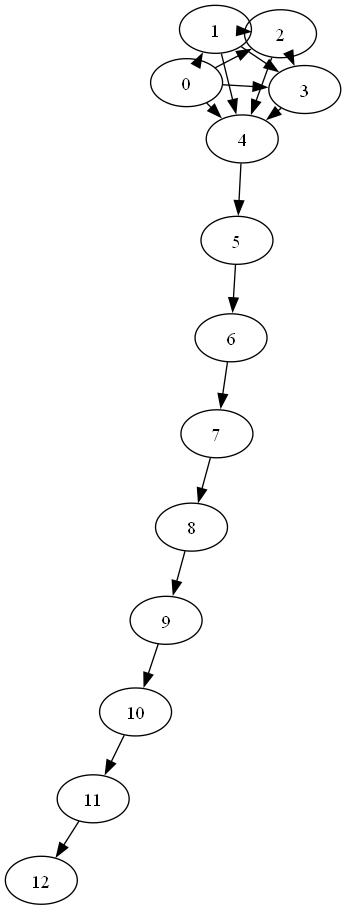

[(0, 1), (0, 2), (0, 3), (0, 4), (1, 2), (1, 3), (1, 4), (2, 3), (2, 4), (3, 4), (5, 6), (6, 7), (7, 8), (8, 9), (9, 10), (10, 11), (11, 12), (4, 5)]


In [4]:
def main(config):
    # Define Coupling map for qubits and total number of qubits
    if config.MODEL == "impurity": 
        num_qubits = config.NUM_SPINS_BATH + config.NUM_SPINS_IMPURITY
    else:
        num_qubits = config.NUM_RINGS * config.NUM_SPINS
    edges = config.EDGES
    if config.PASS_TO_MPS == 'impurity':
        reversed_mapping = {i: num_qubits - 1 - i for i in range(num_qubits)}
        reversed_edges = [ (reversed_mapping[a], reversed_mapping[b]) for (a, b) in edges ]
        edges = reversed_edges

    coupling_map = CouplingMap(edges)
    if config.SHOW_CONFIG:
        config.display_configuration()
        print("=== Coupling Map === ")
        display(coupling_map.draw())
        print(edges)
    
    # Better-looking coupling map plot (maybe for report)
    # plot_coupling_map(coupling_map, config.NUM_RINGS, config.NUM_SPINS)

    
    

class Config:
    """
    Configuration parameters for the quantum simulation.
    """
    def __init__(self, num_spins=3, num_rings=2, num_spins_impurity = None, num_spins_bath = None, anisotropy=0.98, h_field=1.0,
                 two_gates_list=['XX'], single_gates_list=['Z'], pass_to_mps = 'bath',
                 trotter_reps=1, t=0.1, decreasing=False, index_decrease = None, n_samples=np.inf, 
                 edge_probability = 0.5, shots_tensor = 100, model = "ring", with_knitting = True,
                 show_config = False, subcircuits_path = "subcircuits", coeffs_exp_path = "expvals"):
        """
        Initializes the configuration with given parameters.

        Parameters:
        - num_spins (int): Number of qubits per ring.
        - num_rings (int): Total number of rings.
        - num_spins_impurity (int): Use within the impurity model, number of spins in the impurity.
        - num_spins_bath (int): Use within the impurity model, number of spins in the bath.
        - anisotropy (float): Variable J in the Hamiltonian.
        - h_field (float): External magnetic field.
        - two_gates_list (list): List of two-qubit gates in the Hamiltonian.
        - single_gates_list (list): List of single-qubit gates in the Hamiltonian.
        - trotter_reps (int): Number of Trotter repetitions.
        - dt (float): Time parameter.
        - decreasing (bool): Flag for decreasing the intensity of J with distance to the first qubit.
        - index_decrease (int): initial qubit to which the decreasing coupling will be applied.
        - n_samples (int or float): Number of samples for generation of knitting subexperiments.
        - model (string): allows to choose between the different hamiltonian models.
        - with_knitting (bool): Flag to run the simulation with the knitting step.
        - show_config (bool): Flag to display the configuration parameters.
        - subcircuits_path (string): Path to save the subcircuits JSON files.
        - coeffs_exp_path (string): Path to save the coefficients and expectation values JSON files.
        """
        self.NUM_SPINS = num_spins 
        self.NUM_RINGS = num_rings
        self.NUM_SPINS_IMPURITY = num_spins_impurity
        self.NUM_SPINS_BATH = num_spins_bath
        self.ANISOTROPY = anisotropy
        self.H_FIELD = h_field
        self.TWO_GATES_LIST = two_gates_list
        self.SINGLE_GATES_LIST = single_gates_list
        self.MODEL = model  
        self.PASS_TO_MPS = pass_to_mps

        if model == "ring":
            self._build_ring_model()

        elif model == "line":
            self.NUM_RINGS = 1
            self._build_line_model()

        elif model == "impurity":
            # Later I will give the model more configurability. For now, size of bath is the same as size of "impurity". 
            # For ease of use we use 2 "rings". The first one will be the impurity and second will be the bath
            if num_spins_bath is None or num_spins_impurity is None:
                raise ValueError("You have to define num_spins_impurity and num_spins_bath to use the impurity model")
            else:
                self.NUM_SPINS_IMPURITY = num_spins_impurity
                self.NUM_SPINS_BATH = num_spins_bath
                
                self.impurity_qubits = list(range(self.NUM_SPINS_IMPURITY))
                self.bath_qubits = list(range(self.NUM_SPINS_IMPURITY, self.NUM_SPINS_IMPURITY + self.NUM_SPINS_BATH))
                
                self.EDGE_PROB = edge_probability
                random.seed(1)
                self._build_impurity_model()
        else:
            raise ValueError(f"'{model}' is not a valid model. Choose from: 'ring', 'line'. 'impurity'.")
        
        self.TROTTER_REPS = trotter_reps
        self.T = t  

        self.DECREASING = decreasing  
        self.INDEX_DECREASE = index_decrease

        self.N_SAMPLES = n_samples
        self.SHOTS_TENSOR = shots_tensor

        self.WITH_KNITTING = with_knitting
        self.SHOW_CONFIG = show_config
        self.SUBCIRCUITS_PATH = subcircuits_path
        self.COEFFS_EXP_PATH = coeffs_exp_path
        

    def _get_qubit_index(self, ring, qubit):
        return ring * self.NUM_SPINS + qubit

    def _build_impurity_model(self):
        """
        Builds the impurity model consisting of two regions:
        1. Impurity Region: Randomly connected edges within the impurity qubits.
        2. Bath Region: Linearly connected edges within the bath qubits.
        """
        self.impurity_edges = []
        for i in range(self.NUM_SPINS_IMPURITY):
            for j in range(i + 1, self.NUM_SPINS_IMPURITY):
                if random.random() < self.EDGE_PROB:
                    edge = (self.impurity_qubits[i], self.impurity_qubits[j])
                    self.impurity_edges.append(edge)

        self.bath_edges = [(self.bath_qubits[i], self.bath_qubits[i + 1]) for i in range(self.NUM_SPINS_BATH - 1)]

        self.inter_edges = []
        if self.NUM_SPINS_IMPURITY > 0 and self.NUM_SPINS_BATH > 0:
            self.inter_edges.append((self.impurity_qubits[-1], self.bath_qubits[0]))

        self.EDGES = self.impurity_edges + self.bath_edges + self.inter_edges
    
    def _build_ring_model(self):
        self.intra_edges = [
            (self._get_qubit_index(ring, i),
            self._get_qubit_index(ring, (i + 1) % self.NUM_SPINS))
            for ring in range(self.NUM_RINGS)
            for i in range(self.NUM_SPINS)
        ]
        self.inter_edges = self._generate_inter_ring_edges()
        self.EDGES = self.intra_edges + self.inter_edges

    def _build_line_model(self):
        self.EDGES = [(i, i + 1) for i in range(self.NUM_SPINS - 1)]
        

    def display_configuration(self):
        """
        Prints the current configuration for verification.
        """
        print("=== Configuration ===")
        if self.NUM_SPINS_BATH or self.NUM_SPINS_IMPURITY:
            print(f"Number of spins in the bath: {self.NUM_SPINS_BATH}")
            print(f"Number of spins in the impurity: {self.NUM_SPINS_IMPURITY}")
        else:
            print(f"Number of Spins per Ring: {self.NUM_SPINS}")
            print(f"Number of Rings: {self.NUM_RINGS}")
        print(f"Anisotropy (J): {self.ANISOTROPY}")
        print(f"External Magnetic Field (H): {self.H_FIELD}")
        print(f"Two-Qubit Gates: {self.TWO_GATES_LIST}")
        print(f"Single-Qubit Gates: {self.SINGLE_GATES_LIST}")
        print(f"Trotter Repetitions: {self.TROTTER_REPS}")
        print(f"Time Parameter (t): {self.T}")
        print(f"Decreasing J Flag: {self.DECREASING}")
        print(f"Number of circuit samples: {self.N_SAMPLES}")
        print(f"Number of shots (tensor simulation): {self.SHOTS_TENSOR}")
        print("=====================")

if __name__ == "__main__":

    t_step = 1
    t_list = [round(t_step * i, 2) for i in range(1, 2)] # defined in this way to avoid floating point errors
    
    # First we delete and recreate the subcircuits and expvals_coeffs folders
    subcircuits_dir = "subcircuits"
    if os.path.exists(subcircuits_dir):
        shutil.rmtree(subcircuits_dir)
    os.makedirs(subcircuits_dir, exist_ok=True)
    
    coeffs_exp_dir = "expvals"
    if os.path.exists(coeffs_exp_dir):
        shutil.rmtree(coeffs_exp_dir)
    os.makedirs(coeffs_exp_dir, exist_ok=True)
    expvals2 = []
    for t in t_list:
        config = Config(num_spins_impurity = 5, num_spins_bath = 8, two_gates_list=['ZZ'], single_gates_list=['X'], t = t, trotter_reps = 6, shots_tensor = 1000,  
                    model = "impurity", edge_probability=1, with_knitting=True,
                    subcircuits_path=subcircuits_dir, coeffs_exp_path = coeffs_exp_dir, show_config=True,
                    pass_to_mps = 'bath', n_samples = 50000, # Use "bath" to pass bath to MPS (standard practice)
                    decreasing = True, index_decrease = 5)  
        expval = main(config)
        expvals2.append(expval)
    

High-degree nodes: [1, 2, 3, 4, 5]
Low-degree nodes: [6, 7, 8, 9, 10, 11, 12, 13]


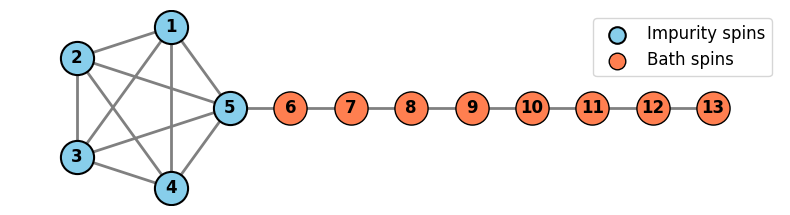

<Figure size 640x480 with 0 Axes>

In [105]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# Define your edges
edges_def = [
    (0, 1), (0, 2), (0, 3), (0, 4),
    (1, 2), (1, 3), (1, 4),
    (2, 3), (2, 4),
    (3, 4),
    (5, 6), (6, 7), (7, 8), (8, 9), (9, 10), (10, 11), (11, 12),
    (4, 5)
]
edges = [(a+1, b+1) for (a, b) in edges_def]

# Create a graph object
G = nx.Graph()
G.add_edges_from(edges)

# 1. Identify High-Degree and Low-Degree Nodes
degrees = dict(G.degree())
high_degree_threshold = 4  # Nodes with degree >= 4 are considered high-degree
high_degree_nodes = [node for node, deg in degrees.items() if deg >= high_degree_threshold]
low_degree_nodes = [node for node in G.nodes() if node not in high_degree_nodes]

print("High-degree nodes:", high_degree_nodes)
print("Low-degree nodes:", low_degree_nodes)

# 2. Create Custom Shell Layout for High-Degree Nodes with Vertex 4 at Rightmost Position

# a. Determine the number of high-degree nodes
num_high = len(high_degree_nodes)

# b. Define angles for each high-degree node, ensuring vertex 4 is at 0 degrees (rightmost)
# Sort high-degree nodes to place vertex 4 first
sorted_high_degree = sorted(high_degree_nodes)
if 5 in sorted_high_degree:
    sorted_high_degree.remove(5)
    sorted_high_degree = [5] + sorted_high_degree  # Place vertex 4 first

# c. Calculate angles
angles = {}
angle_step = 2 * np.pi / num_high
for i, node in enumerate(sorted_high_degree):
    angles[node] = 0 + i * angle_step  # Start at 0 radians

# d. Assign positions on the unit circle (radius can be scaled later)
shell_pos = {}
radius = 1.4  # Adjust radius as needed for spacing
for node in high_degree_nodes:
    theta = angles[node]
    x = radius * np.cos(theta)
    y = radius * np.sin(theta)
    shell_pos[node] = (x, y)

# 3. Align Low-Degree Nodes Horizontally with Vertex 4

# a. Determine the y-coordinate of vertex 4
y_vertex4 = shell_pos[5][1]  # Should be 0 since vertex 4 is at 0 radians

# b. Arrange low-degree nodes horizontally to the right of the shell
# Start placing them slightly to the right of the shell radius
start_x = radius + 1  # Adjust spacing as needed
spacing = 1  # Space between low-degree nodes

linear_pos = {}
for i, node in enumerate(low_degree_nodes):
    x = start_x + i * spacing
    y = y_vertex4  # Align vertically with vertex 4
    linear_pos[node] = (x, y)

# 4. Combine Positions
pos = {}
pos.update(shell_pos)
pos.update(linear_pos)

# 5. Plotting the Graph

# Initialize the plot
plt.figure(figsize=(8, 2.25))

# a. Draw High-Degree Nodes
nx.draw_networkx_nodes(
    G, pos,
    nodelist=high_degree_nodes,
    node_size=570,
    node_color='skyblue',
    edgecolors='black',
    linewidths=1.5,
    label='Impurity spins'
)

# b. Draw Low-Degree Nodes
nx.draw_networkx_nodes(
    G, pos,
    nodelist=low_degree_nodes,
    node_size=570,
    node_color='coral',
    edgecolors='black',
    linewidths=1.0,
    label='Bath spins'
)

# c. Draw Edges
nx.draw_networkx_edges(G, pos, width=2, edge_color='gray')

# d. Draw Labels
labels = {node: str(node) for node in G.nodes()}
nx.draw_networkx_labels(G, pos, labels, font_size=12, font_weight='bold')

# e. Add Legend
plt.legend(scatterpoints = 1,fontsize = 12, markerscale = 0.5, loc='upper right')

# f. Remove Axes for a Cleaner Look
plt.axis('off')

# g. Adjust Layout for Better Spacing
plt.tight_layout()

# h. Display the Graph
plt.show()

# i. Save the Figure with High Resolution for Your Paper
plt.savefig('custom_layout_graph.png', format='PNG', dpi=300, bbox_inches='tight')


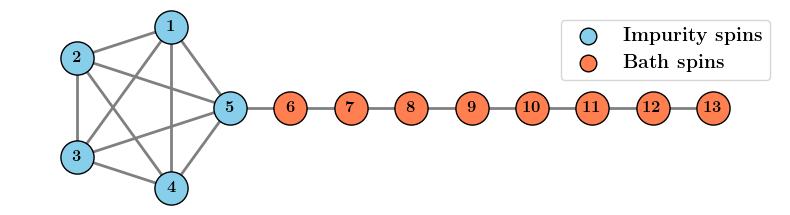

<Figure size 640x480 with 0 Axes>

In [5]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# Enable LaTeX font rendering
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Define your edges
edges_def = [
    (0, 1), (0, 2), (0, 3), (0, 4),
    (1, 2), (1, 3), (1, 4),
    (2, 3), (2, 4),
    (3, 4),
    (5, 6), (6, 7), (7, 8), (8, 9), (9, 10), (10, 11), (11, 12),
    (4, 5)
]
edges = [(a+1, b+1) for (a, b) in edges_def]

# Create a graph object
G = nx.Graph()
G.add_edges_from(edges)

# 1. Identify High-Degree and Low-Degree Nodes
degrees = dict(G.degree())
high_degree_threshold = 4  # Nodes with degree >= 4 are considered high-degree
high_degree_nodes = [node for node, deg in degrees.items() if deg >= high_degree_threshold]
low_degree_nodes = [node for node in G.nodes() if node not in high_degree_nodes]

# 2. Create Custom Shell Layout for High-Degree Nodes with Vertex 4 at Rightmost Position

# a. Determine the number of high-degree nodes
num_high = len(high_degree_nodes)

# b. Define angles for each high-degree node, ensuring vertex 4 is at 0 degrees (rightmost)
sorted_high_degree = sorted(high_degree_nodes)
if 5 in sorted_high_degree:
    sorted_high_degree.remove(5)
    sorted_high_degree = [5] + sorted_high_degree  # Place vertex 4 first

# c. Calculate angles
angles = {}
angle_step = 2 * np.pi / num_high
for i, node in enumerate(sorted_high_degree):
    angles[node] = 0 + i * angle_step  # Start at 0 radians

# d. Assign positions on the unit circle
shell_pos = {}
radius = 1.4  # Adjust radius as needed
for node in high_degree_nodes:
    theta = angles[node]
    x = radius * np.cos(theta)
    y = radius * np.sin(theta)
    shell_pos[node] = (x, y)

# 3. Align Low-Degree Nodes Horizontally with Vertex 4
y_vertex4 = shell_pos[5][1]  # Should be 0 since vertex 4 is at 0 radians
start_x = radius + 1  # Adjust spacing as needed
spacing = 1  # Space between low-degree nodes

linear_pos = {}
for i, node in enumerate(low_degree_nodes):
    x = start_x + i * spacing
    y = y_vertex4  # Align vertically with vertex 4
    linear_pos[node] = (x, y)

# 4. Combine Positions
pos = {}
pos.update(shell_pos)
pos.update(linear_pos)

# 5. Plotting the Graph
plt.figure(figsize=(8, 2.25))

# a. Draw High-Degree Nodes
nx.draw_networkx_nodes(
    G, pos,
    nodelist=high_degree_nodes,
    node_size=570,
    node_color='skyblue',
    edgecolors='black',
    linewidths=1,
    label=r'\textbf{Impurity spins}'
)

# b. Draw Low-Degree Nodes
nx.draw_networkx_nodes(
    G, pos,
    nodelist=low_degree_nodes,
    node_size=570,
    node_color='coral',
    edgecolors='black',
    linewidths=1.0,
    label=r'\textbf{Bath spins}'
)

# c. Draw Edges
nx.draw_networkx_edges(G, pos, width=2, edge_color='gray')

# d. Draw Labels
labels = {node: rf'\textbf{{{node}}}' for node in G.nodes()}
nx.draw_networkx_labels(G, pos, labels, font_size=12)

# e. Add Legend
plt.legend(scatterpoints=1, fontsize=14, markerscale=0.5, loc='upper right')

# f. Remove Axes for a Cleaner Look
plt.axis('off')

# g. Adjust Layout for Better Spacing
plt.tight_layout()

# h. Display the Graph
plt.show()

# i. Save the Figure with High Resolution for Your Paper
plt.savefig('custom_layout_graph_latex.png', format='PNG', dpi=300, bbox_inches='tight')


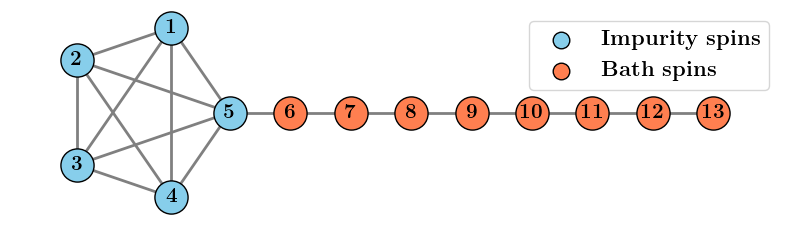

In [11]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# Enable LaTeX font rendering
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Define your edges
edges_def = [
    (0, 1), (0, 2), (0, 3), (0, 4),
    (1, 2), (1, 3), (1, 4),
    (2, 3), (2, 4),
    (3, 4),
    (5, 6), (6, 7), (7, 8), (8, 9), (9, 10), (10, 11), (11, 12),
    (4, 5)
]
edges = [(a+1, b+1) for (a, b) in edges_def]

# Create a graph object
G = nx.Graph()
G.add_edges_from(edges)

# 1. Identify High-Degree and Low-Degree Nodes
degrees = dict(G.degree())
high_degree_threshold = 4  # Nodes with degree >= 4 are considered high-degree
high_degree_nodes = [node for node, deg in degrees.items() if deg >= high_degree_threshold]
low_degree_nodes = [node for node in G.nodes() if node not in high_degree_nodes]

# 2. Create Custom Shell Layout for High-Degree Nodes with Vertex 4 at Rightmost Position

# a. Determine the number of high-degree nodes
num_high = len(high_degree_nodes)

# b. Define angles for each high-degree node, ensuring vertex 4 is at 0 degrees (rightmost)
sorted_high_degree = sorted(high_degree_nodes)
if 5 in sorted_high_degree:
    sorted_high_degree.remove(5)
    sorted_high_degree = [5] + sorted_high_degree  # Place vertex 4 first

# c. Calculate angles
angles = {}
angle_step = 2 * np.pi / num_high
for i, node in enumerate(sorted_high_degree):
    angles[node] = 0 + i * angle_step  # Start at 0 radians

# d. Assign positions on the unit circle
shell_pos = {}
radius = 1.4  # Adjust radius as needed
for node in high_degree_nodes:
    theta = angles[node]
    x = radius * np.cos(theta)
    y = radius * np.sin(theta)
    shell_pos[node] = (x, y)

# 3. Align Low-Degree Nodes Horizontally with Vertex 4
y_vertex4 = shell_pos[5][1]  # Should be 0 since vertex 4 is at 0 radians
start_x = radius + 1  # Adjust spacing as needed
spacing = 1  # Space between low-degree nodes

linear_pos = {}
for i, node in enumerate(low_degree_nodes):
    x = start_x + i * spacing
    y = y_vertex4  # Align vertically with vertex 4
    linear_pos[node] = (x, y)

# 4. Combine Positions
pos = {}
pos.update(shell_pos)
pos.update(linear_pos)

# 5. Plotting the Graph
plt.figure(figsize=(8, 2.35))

# a. Draw High-Degree Nodes
nx.draw_networkx_nodes(
    G, pos,
    nodelist=high_degree_nodes,
    node_size=570,
    node_color='skyblue',
    edgecolors='black',
    linewidths=1,
    label=r'\textbf{Impurity spins}'
)

# b. Draw Low-Degree Nodes
nx.draw_networkx_nodes(
    G, pos,
    nodelist=low_degree_nodes,
    node_size=570,
    node_color='coral',
    edgecolors='black',
    linewidths=1.0,
    label=r'\textbf{Bath spins}'
)

# c. Draw Edges
nx.draw_networkx_edges(G, pos, width=2, edge_color='gray')

# d. Draw Labels with Bold Numbers
labels = {node: rf'$\mathbf{{{node}}}$' for node in G.nodes()}  # Bold numbers using \mathbf
nx.draw_networkx_labels(G, pos, labels, font_size=15)

# e. Add Legend
plt.legend(scatterpoints=1, fontsize=16, markerscale=0.5, loc='upper right')

# f. Remove Axes for a Cleaner Look
plt.axis('off')

# g. Adjust Layout for Better Spacing
plt.tight_layout()

plt.savefig('coupling_map.png', format='PNG', dpi=300, bbox_inches='tight')
# h. Display the Graph
plt.show()
